In [1]:
from __future__ import division
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, copy
from scipy.stats import *
from pylab import plot, show, legend
from tqdm import trange
from kalman import *

In [2]:
A = np.asarray([[0.8, -0.1], [0, 1]])
C = np.asarray([[0.1, 0.5], [-0.3, 0.0]])
dim = np.shape(A)[0]
sigmax2 = 1
sigmay2 = 1
Q = sigmax2*np.eye(dim)
R = sigmay2*np.eye(dim)
mu0 = np.zeros(dim)
Sigma0 = np.eye(dim)

In [3]:
T = 50
Y, X = generate_data_linear_gaussian(mu0, Sigma0, A, C, Q, R, T)

#### Sanity check:

In [4]:
n_particles = 1000
logNC, particles = bootstrap_PF(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_particles)

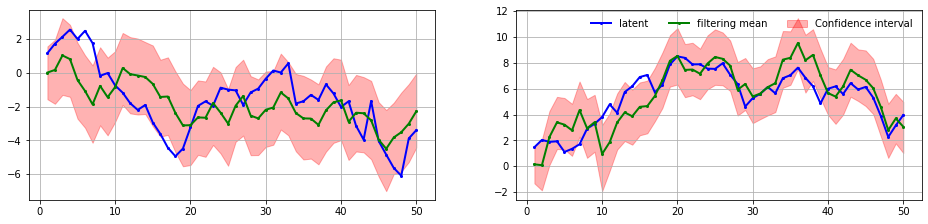

In [5]:
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(np.arange(1,T+1), X[:,i],  "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(np.arange(1,T+1), np.mean(particles[:,:,i],axis=1), "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(1,T+1), 
                     np.percentile(particles[:,:,i],axis=1,q=5), 
                     np.percentile(particles[:,:,i],axis=1,q=95), 
                     color='red', alpha=.3, label="Confidence interval")
    plt.grid(True)
plt.legend(ncol=3, frameon=False)

In [6]:
ll = np.asarray([bootstrap_PF(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, 100)[0] for i in range(200)])
print(np.var(ll))

0.8649785555247231


In [7]:
n_particles = 100
n_mcmc = 1_000
scale = np.asarray([0.7, 0.3])

### Particle:

100%|██████████| 1000/1000 [02:14<00:00,  7.36it/s]


35.5 % acceptance rate


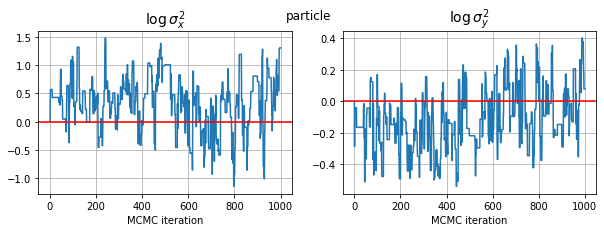

In [8]:
power = 1
log_sigmay2_chain_pf1, log_sigmax2_chain_pf1, accepted_pf1, scales_pf1 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/np.sqrt(power), 
              method="particle", n_particles=100, power=power)

plot(log_sigmax2_chain_pf1, log_sigmay2_chain_pf1, sigmax2, sigmay2, title="particle")

100%|██████████| 1000/1000 [15:13<00:00,  1.13it/s]


28.7 % acceptance rate


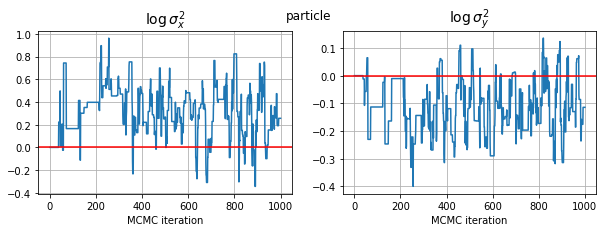

In [10]:
power = 5
log_sigmay2_chain_pf5, log_sigmax2_chain_pf5, accepted_pf5, scales_pf5 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale, 
              method="particle", n_particles=500, power=power)

plot(log_sigmax2_chain_pf5, log_sigmay2_chain_pf5, sigmax2, sigmay2, title="particle")

In [ ]:
plot(log_sigmax2_chain_pf10, log_sigmay2_chain_pf10, sigmax2, sigmay2, title="particle")

In [14]:
accepted_pf10/n_mcmc*100

6.660000000000001

### Kalman:

100%|██████████| 10000/10000 [02:39<00:00, 62.60it/s]


63.25 % acceptance rate


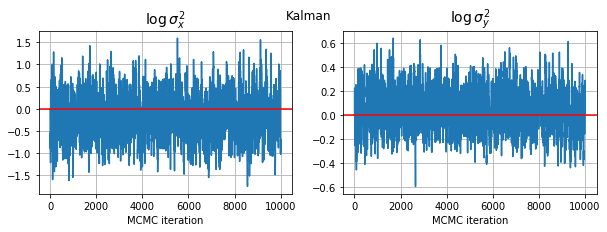

In [15]:
power = 1
log_sigmay2_chain_kp1, log_sigmax2_chain_kp1, accepted_kp5, scales_kp1 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/np.sqrt(power), method="kalman", power=power)

plot(log_sigmax2_chain_kp1, log_sigmay2_chain_kp1, sigmax2, sigmay2, title="Kalman")

100%|██████████| 10000/10000 [02:41<00:00, 61.90it/s]


63.7 % acceptance rate


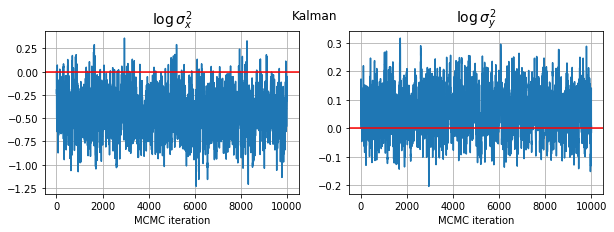

In [16]:
power = 5
log_sigmay2_chain_kp5, log_sigmax2_chain_kp5, accepted_kp5, scales_kp5 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/np.sqrt(power), method="kalman", power=power)

plot(log_sigmax2_chain_kp5, log_sigmay2_chain_kp5, sigmax2, sigmay2, title="Kalman")

100%|██████████| 10000/10000 [02:43<00:00, 61.34it/s]


63.4 % acceptance rate


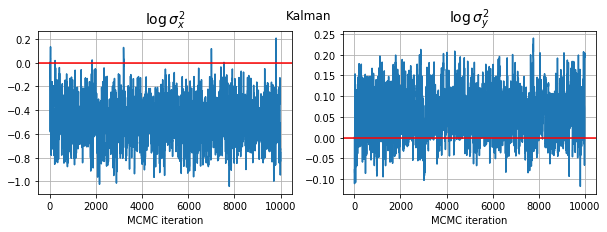

In [17]:
power = 10
log_sigmay2_chain_kp10, log_sigmax2_chain_kp10, accepted_kp10, scales_kp10 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/np.sqrt(power), method="kalman", power=power)

plot(log_sigmax2_chain_kp10, log_sigmay2_chain_kp10, sigmax2, sigmay2, title="Kalman")

In [10]:
print(np.round([np.mean(np.exp(log_sigmay2_chain_kp1)), 
                np.mean(np.exp(log_sigmay2_chain_kp5)), 
                np.mean(np.exp(log_sigmay2_chain_kp10))],2))
print(np.round([np.var(np.exp(log_sigmay2_chain_kp1))/np.var(np.exp(log_sigmay2_chain_kp5)),
                np.var(np.exp(log_sigmay2_chain_kp1))/np.var(np.exp(log_sigmay2_chain_kp10))],1))

[0.95 0.95 0.95]
[ 5.3 10.6]


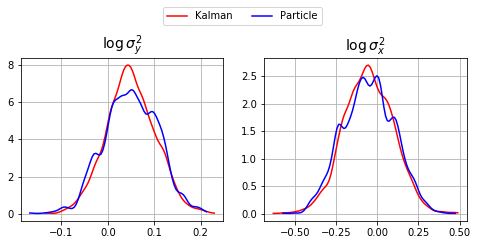

In [28]:
plt.rcParams['figure.figsize'] = (8, 3)
plt.subplot(121)
x_vals = np.linspace(start=np.min(log_sigmay2_chain_kalman), 
                     stop=np.max(log_sigmay2_chain_kalman), num=100)
plt.plot(x_vals, gaussian_kde(log_sigmay2_chain_kalman) (x_vals), color='r', label="Kalman")
x_vals = np.linspace(start=np.min(log_sigmay2_chain_particle), 
                     stop=np.max(log_sigmay2_chain_particle), num=100)
plt.plot(x_vals, gaussian_kde(log_sigmay2_chain_particle) (x_vals), color='b', label="Particle")
plt.title(r"$\log \, \sigma_y^2$", fontsize=14)
plt.grid(True)

plt.subplot(122)
x_vals = np.linspace(start=np.min(log_sigmax2_chain_kalman), 
                     stop=np.max(log_sigmax2_chain_kalman), num=100)
plt.plot(x_vals, gaussian_kde(log_sigmax2_chain_kalman) (x_vals), color='r', label="Kalman")
x_vals = np.linspace(start=np.min(log_sigmax2_chain_particle), 
                     stop=np.max(log_sigmax2_chain_particle), num=100)
plt.plot(x_vals, gaussian_kde(log_sigmax2_chain_particle) (x_vals), color='b', label="Particle")
plt.grid(True)
plt.title(r"$\log \, \sigma_x^2$", fontsize=14)

plt.legend(loc=[-0.5,1.2], ncol=2);

In [37]:
stat, p = normaltest(log_sigmax2_chain_particle)
print('Statistics = %.2f, p = %.3f' % (stat, p))
stat, p = normaltest(log_sigmay2_chain_particle)
print('Statistics = %.2f, p = %.3f' % (stat, p))

stat, p = normaltest(log_sigmax2_chain_kalman)
print('Statistics = %.2f, p = %.3f' % (stat, p))
stat, p = normaltest(log_sigmay2_chain_kalman)
print('Statistics = %.2f, p = %.3f' % (stat, p))

Statistics = 112.29, p = 0.000
Statistics = 20.37, p = 0.000
Statistics = 2.39, p = 0.303
Statistics = 6.47, p = 0.039


In [29]:
power = 1
log_sigmay2_chain_kp1, log_sigmax2_chain_kp1, accepted_kp1, scales_kp1 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/power, method="kalman", power=power)

100%|██████████| 10000/10000 [05:02<00:00, 32.96it/s]


In [32]:
print(np.var(log_sigmay2_chain_kp1)/np.var(log_sigmay2_chain_kalman))
print(np.var(log_sigmax2_chain_kp1)/np.var(log_sigmax2_chain_kalman))

4.844330753457106
4.429945606560791


In [38]:
print(np.var(log_sigmay2_chain_kp1)/np.var(log_sigmay2_chain_particle))
print(np.var(log_sigmax2_chain_kp1)/np.var(log_sigmax2_chain_particle))

4.176394841101921
4.103882918724597
